In [1]:
import theano
from theano import *

THEANO_FLAGS = "optimizer=fast_compile"

import numpy as np
import pandas as pd
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import curve_fit
from scipy import stats
import arviz as az

import pymc3 as pm
from pymc3.ode import DifferentialEquation

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
plt.style.use("seaborn-darkgrid")
rcParams.update({'font.size': 13, 'figure.figsize': (8, 6)})
import seaborn as sns

In [2]:
fluo = pd.read_csv('datasets/fluoOD-all.csv')
od = pd.read_csv('datasets/OD-all.csv')

fluo = fluo.replace('n.a.', 0)
od = od.replace('n.a.', 0)
raw_fluo = fluo.drop(['ECF', 'Intein', 'Ara', 'Cuma'], axis=1).astype(float)
raw_od = od.drop(['ECF', 'Intein', 'Ara', 'Cuma'], axis=1).astype(float)

raw_both = raw_fluo * raw_od
df = pd.concat([fluo[['ECF', 'Intein', 'Ara', 'Cuma']], raw_both], axis=1)
df.head()

,ECF,Intein,Ara,Cuma,0 days 00:00:00,0 days 00:20:00,0 days 00:40:00,0 days 01:00:00,0 days 01:20:00,0 days 01:40:00,...,0 days 21:00:00,0 days 21:20:00,0 days 21:40:00,0 days 22:00:00,0 days 22:20:00,0 days 22:40:00,0 days 23:00:00,0 days 23:20:00,0 days 23:40:00,1 days 00:00:00
0,e15,SspGyrB,0.0,0.0,86.07150,82.06954,88.38960,62.19079,116.70200,102.28023,...,1193.86295,861.74594,886.82806,906.52672,954.23286,954.11381,956.86138,976.53270,994.16833,1046.42904
1,e22,SspGyrB,0.0,0.0,22.54775,-18.98564,58.63742,-45.45408,65.89592,58.12736,...,1227.80900,897.98016,916.36444,965.78421,960.47120,966.81970,969.84264,921.83168,949.05612,982.81940
2,e32,SspGyrB,0.0,0.0,75.20260,104.01251,44.93160,62.36598,71.43251,87.39756,...,1027.60350,697.47708,749.63888,764.47200,757.70032,739.12700,787.83970,766.74492,800.26327,842.45760
3,e33,SspGyrB,0.0,0.0,-8.42960,96.98220,7.59312,52.39984,67.84287,72.73070,...,823.24245,472.01400,504.59024,590.86192,600.05140,559.76726,597.98718,521.19110,552.31101,580.62816
4,e34,SspGyrB,0.0,0.0,22.00288,82.54920,29.65143,50.74575,54.87110,95.95276,...,1297.91520,968.00364,1014.76755,1036.70118,1058.16900,1052.08920,1042.23177,1035.68976,1013.41752,1041.92511


In [3]:
df2 = df[(df['Ara']==1) & (df['Cuma']==1)]
df2 = df2.set_index(df2['ECF'] + df2['Intein'])
df2 = df2.drop(['ECF', 'Intein', 'Ara', 'Cuma'], axis=1).transpose()
df2['new_index'] = df2.index.str[7:12]
df2 = df2.set_index('new_index')
df2.head()

,e15SspGyrB,e22SspGyrB,e32SspGyrB,e33SspGyrB,e34SspGyrB,e41SspGyrB,e42SspGyrB,e15TerThyXS2,e22TerThyXS2,e38TerThyXS2,...,e33TerThyXS1,e15STPhoRadA,e16STPhoRadA,e17STPhoRadA,e20STPhoRadA,e22STPhoRadA,e26STPhoRadA,e32STPhoRadA,e33STPhoRadA,e34STPhoRadA
new_index,,,,,,,,,,,,,,,,,,,,,
00:00,21.62500,14.10682,-10.20240,-14.73152,33.51864,54.76527,30.03510,30.74070,76.93035,98.94185,...,62.13312,17.90467,-6.91299,24.62000,76.44860,19.578000,-10.77699,24.425500,12.62616,31.97744
00:20,-101.37366,64.33200,63.38460,87.34615,175.67310,99.96154,89.73077,173.29753,127.39316,161.16140,...,-129.68964,-137.81250,-85.89522,62.82879,126.96154,92.153847,109.12588,107.615385,156.70011,160.07416
00:40,-52.95490,-38.89568,-37.80715,-46.18264,-12.37340,-2.86740,-48.26601,-15.48820,-18.92473,20.74640,...,-42.28900,-63.66528,-55.83582,-41.68976,-12.08031,-17.210700,-12.37340,-42.180800,13.03740,58.06452
01:00,-98.18847,-10.39050,23.09808,-15.46116,52.78819,24.15460,31.13992,42.37074,37.52530,56.37600,...,-87.81814,-119.76525,-93.24080,-7.20240,47.33113,-13.380450,5.12220,27.694420,7.57491,61.09570
01:20,-53.51717,13.43900,6.63873,4.95120,42.97700,18.45877,25.04068,60.71615,64.04811,27.90936,...,-61.15626,-95.25761,-49.29870,-0.86548,22.69449,7.170800,8.86480,-0.989730,33.28956,44.47770


In [4]:
df3 = od[(od['Ara']==1) & (od['Cuma']==1)]
df3 = df3.set_index(df3['ECF'] + df3['Intein'])
df3 = df3.drop(['ECF', 'Intein', 'Ara', 'Cuma'], axis=1).transpose()
df3['new_index'] = df3.index.str[7:12]
df3 = df3.set_index('new_index')
df3.head()

,e15SspGyrB,e22SspGyrB,e32SspGyrB,e33SspGyrB,e34SspGyrB,e41SspGyrB,e42SspGyrB,e15TerThyXS2,e22TerThyXS2,e38TerThyXS2,...,e33TerThyXS1,e15STPhoRadA,e16STPhoRadA,e17STPhoRadA,e20STPhoRadA,e22STPhoRadA,e26STPhoRadA,e32STPhoRadA,e33STPhoRadA,e34STPhoRadA
new_index,,,,,,,,,,,,,,,,,,,,,
00:00,0.025,0.026,0.040,0.032,0.024,0.0210,0.0300,0.010,0.015,-0.001,...,0.002,0.007,0.021,0.020,0.0100,0.0200,0.021,0.0250,0.024,0.016
00:20,0.018,0.004,0.004,0.001,-0.006,-0.0004,-0.0002,-0.007,-0.004,-0.005,...,0.018,0.021,0.017,0.003,-0.0004,0.0003,-0.002,-0.0001,-0.007,-0.008
00:40,0.019,0.016,0.017,0.014,0.010,0.0120,0.0130,0.007,0.011,0.008,...,0.013,0.018,0.017,0.014,0.0110,0.0130,0.010,0.0160,0.006,0.002
01:00,0.031,0.015,0.012,0.011,0.007,0.0100,0.0070,0.003,0.005,0.009,...,0.023,0.033,0.029,0.015,0.0110,0.0150,0.010,0.0130,0.007,0.002
01:20,0.037,0.020,0.021,0.016,0.011,0.0170,0.0140,0.005,0.007,0.018,...,0.022,0.037,0.033,0.022,0.0170,0.0260,0.016,0.0210,0.012,0.005


[0.30576577 1.04091593]


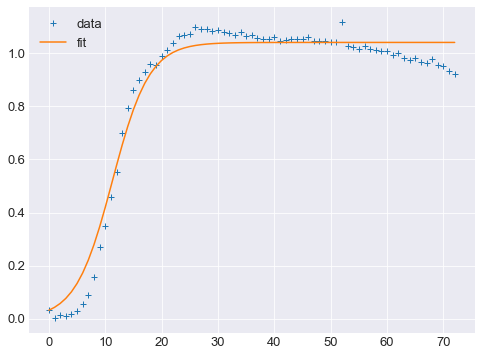

In [5]:
col = 3
odata = df3[df3.columns[col]]
t = list(range(0, len(odata.index)))

def testfunc(t, k1, k2):
    
    def cell_density_model(OD, t, max_growth_rate, max_carry_capacity):
        dOD = (max_growth_rate * (1 - (OD[0]/max_carry_capacity))) * OD[0]
        return dOD
    
    Ca0 = np.abs(odata[0])
    rates = (k1, k2)
    Casol = odeint(cell_density_model, Ca0, t, rates)
    return Casol[:,0]

k_fit, kcov = curve_fit(testfunc, t, odata)
print(k_fit)
fit = testfunc(t, *k_fit)

plt.plot(t, odata, '+', label='data')
plt.plot(t, fit, '-', label='fit')
plt.legend(loc='best')
plt.show()

In [10]:
def and_gate(y, t, p):
        
    an = p[0]
    dn = p[1]
    ac = p[2]
    dc = p[3]
    ae = p[4]
    de = p[5]
    ag = p[6]
    dg = p[7]
    K = p[8]
    n = p[9]

    OD = y[0]
    ECF_n = y[1]
    ECF_c = y[2]
    ECF = y[3]
    GFP = y[4]
    mgc = k_fit[0]
    mgr = k_fit[1]

    dOD = mgr * (1 - (OD/mgc)) * OD
    dECF_n = an - (dn + (mgr * (1 - (OD/mgc)))) * ECF_n
    dECF_c = ac - (dc + (mgr * (1 - (OD/mgc)))) * ECF_c
    dECF = ae * ECF_n * ECF_c - (de + (mgr * (1 - (OD/mgc)))) * ECF
    dGFP = ag * ((ECF**n) / (ECF**n+ K**n))  - (dg + (mgr * (1 - (OD/mgc)))) * GFP

    return [dOD, dECF_n, dECF_c, dECF, dGFP]

In [46]:
fdata = df2[df2.columns[col]].values
fobs = [[i, i, i, i, i] for i in fdata]
t = [i*20 for i in list(np.arange(len(fdata)))]

gate_ode = DifferentialEquation (
    func = and_gate,
    times = t,
    n_states = 5,
    n_theta = 10
)

with pm.Model() as basic_model:
    
    an = pm.Normal("an", mu=0, sigma=2)
    dn = pm.Normal("dn", mu=0, sigma=2)
    ac = pm.Normal("ac", mu=0, sigma=2)
    dc = pm.Normal("dc", mu=0, sigma=2)
    ae = pm.Normal("ae", mu=0, sigma=2)
    de = pm.Normal("de", mu=0, sigma=2)
    ag = pm.Normal("ag", mu=0, sigma=2)
    dg = pm.Normal("dg", mu=0, sigma=2)
    K = pm.Normal("K", mu=0, sigma=2)
    n = pm.Normal("n", mu=0, sigma=2)
    
    gate_model = gate_ode(y0=[np.abs(odata[0]), 0.01, 0.01, 0.01, np.abs(fdata[0])],
                         theta=[an, dn, ac, dc, ae, de, ag, dg, K, n])
    
    sigma = pm.HalfNormal("sigma", sigma=1)
    Y_obs = pm.Normal('Y_obs', mu=gate_model, sd=sigma, observed=fobs)
    
    step = pm.Metropolis()
    trace = pm.sample(100, step=step)

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'an': array(0.), 'dn': array(0.), 'ac': array(0.), 'dc': array(0.), 'ae': array(0.), 'de': array(0.), 'ag': array(0.), 'dg': array(0.), 'K': array(0.), 'n': array(0.), 'sigma_log__': array(-0.22579135)}

Initial evaluation results:
an            -1.61
dn            -1.61
ac            -1.61
dc            -1.61
ae            -1.61
de            -1.61
ag            -1.61
dg            -1.61
K             -1.61
n             -1.61
sigma_log__   -0.77
Y_obs           NaN
Name: Log-probability of test_point, dtype: float64

In [ ]:
def simplest_hill_equation(x, K, n):
    return x**n / (K**n + x**n)

def fitfunc(t, xan, xdn, xac, xdc, xae, xde, xag, xdg, xK, xn, xCa0):
    
    an = xan
    dn = xdn
    ac = xac
    dc = xdc
    ae = xae
    de = xde
    ag = xag
    dg = xdg
    mgr = k_fit[0]
    mgc = k_fit[1]
    K = xK
    n = xn
    Ca0 = xCa0
    
    def andGate(y, t):
        
        [OD, ECF_n, ECF_c, ECF, GFP] = y
        dOD = mgr * (1 - (OD/mgc)) * OD
        dECF_n = an - (dn + (mgr * (1 - (OD/mgc)))) * ECF_n
        dECF_c = ac - (dc + (mgr * (1 - (OD/mgc)))) * ECF_c
        dECF = ae * ECF_n * ECF_c - (de + (mgr * (1 - (OD/mgc)))) * ECF
        dGFP = ag * simplest_hill_equation(ECF, K, n)  - (dg + (mgr * (1 - (OD/mgc)))) * GFP
        
        return [dOD, dECF_n, dECF_c, dECF, dGFP]
    
    Casol = odeint(andGate, Ca0, t)
    return Casol[:,4]

def modelfit(t, xan, xdn, xac, xdc, xae, xde, xag, xdg, xK, xn):
    return fitfunc(t, xan, xdn, xac, xdc, xae, xde, xag, xdg, xK, xn, Ca0)

In [45]:
fdata = df2[df2.columns[col]].values
t = [i*20 for i in list(np.arange(len(fdata)))]

gate_ode = DifferentialEquation (
    func = and_gate,
    times = t,
    n_states = 5,
    n_theta = 10
)

with pm.Model() as basic_model:
    
    an = pm.Normal("an", mu=0, sigma=2)
    dn = pm.Normal("dn", mu=0, sigma=2)
    ac = pm.Normal("ac", mu=0, sigma=2)
    dc = pm.Normal("dc", mu=0, sigma=2)
    ae = pm.Normal("ae", mu=0, sigma=2)
    de = pm.Normal("de", mu=0, sigma=2)
    ag = pm.Normal("ag", mu=0, sigma=2)
    dg = pm.Normal("dg", mu=0, sigma=2)
    K = pm.Normal("K", mu=0, sigma=2)
    n = pm.Normal("n", mu=0, sigma=2)
    
    gate_model = fitfunc(t, an, dn, ac, dc, ae, de, ag, dg, K, n,
                         y0[np.abs(odata[0]), 0.01, 0.01, 0.01, np.abs(fdata[0])])
    
    sigma = pm.HalfNormal("sigma", sigma=1)
    Y_obs = pm.Normal('Y_obs', mu=gate_model, sd=sigma, observed=fobs)
    
    step = pm.Metropolis()
    trace = pm.sample(100, step=step)

ValueError: setting an array element with a sequence.